#EDA Tips dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tipsdata import TipsData
from tipspipe import TipsPipe

plt.style.use('bmh')

## Data download
Data is downloaded  using TipsData class. It checks if data exists, if not sets up file structure and downloads data to raw folder.The class can return raw data or data split in train, val and test. Since the dataset is clean there is no need for a process pipeline.

In [2]:
dataset = TipsData()
dataset.prepare_data(train_split = 0.8, val_split = 0.2, test_split = 0.)
dataset.setup()

Returns the full raw dataset in a dataframe with features and labels in XY, only features in X and only lables in y.
Checking table properities shape, feature names and type and label name. 

In [3]:
XY, X,y = dataset.get_raw_data()

print(f'X shape: {X.shape}, y shape: {y.shape}')
print(f'X columns: {X.columns}\n')
print(f'X feature types: \n {X.dtypes}\n')
print(f'y label type: \n {y.dtypes}')

X shape: (244, 6), y shape: (244, 1)
X columns: Index(['tip', 'sex', 'smoker', 'day', 'time', 'g_size'], dtype='object')

X feature types: 
 tip       float64
sex        object
smoker     object
day        object
time       object
g_size      int64
dtype: object

y label type: 
 total_bill    float64
dtype: object


Get unique categorical classes.

In [4]:
#Get unique values
disc_feature_list = X.select_dtypes(exclude='float64').columns
disc_dict = {}
for i in disc_feature_list:
    print(f'{i}: {X[i].unique()}')
    disc_dict[i] = X[i].unique()

sex: ['Female' 'Male']
smoker: ['No' 'Yes']
day: ['Sun' 'Sat' 'Thur' 'Fri']
time: ['Dinner' 'Lunch']
g_size: [2 3 4 1 6 5]


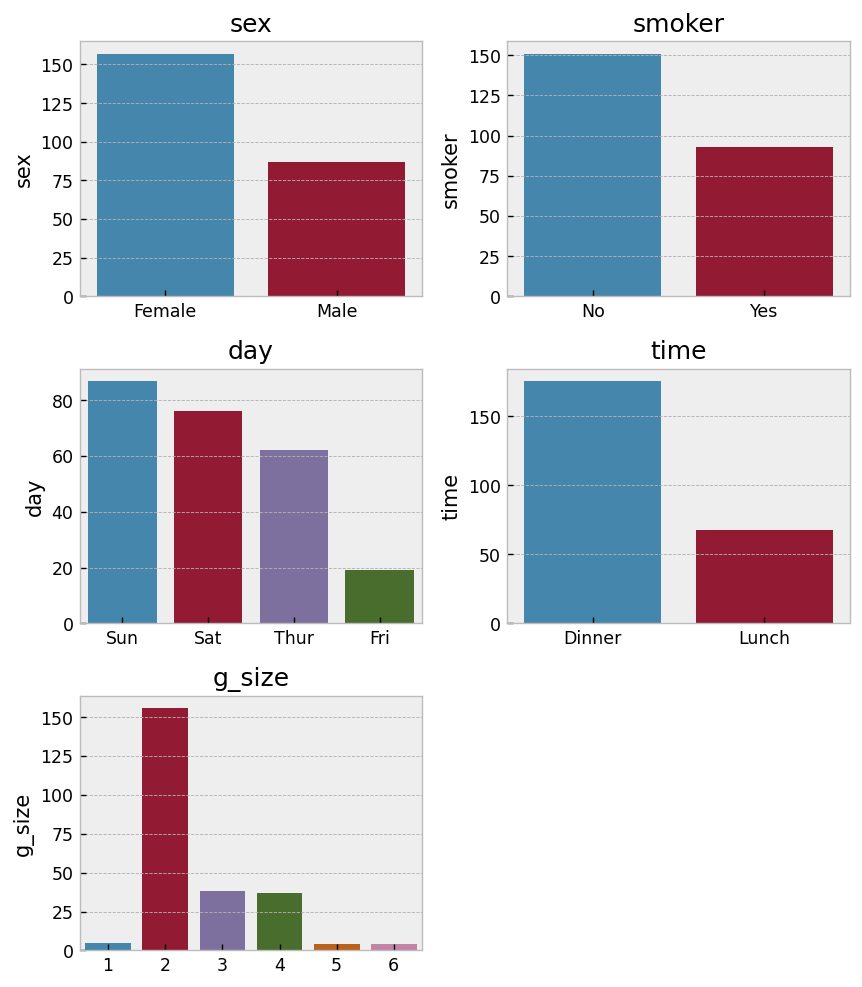

In [5]:
#Check class balance

plt.figure(figsize=(7,8), dpi=125)
for i,k in enumerate(disc_dict):
    plt.subplot(3,2,i+1)
    sns.barplot(x=disc_dict[k], y=X[k].value_counts())
    plt.title(k)
    plt.tight_layout()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

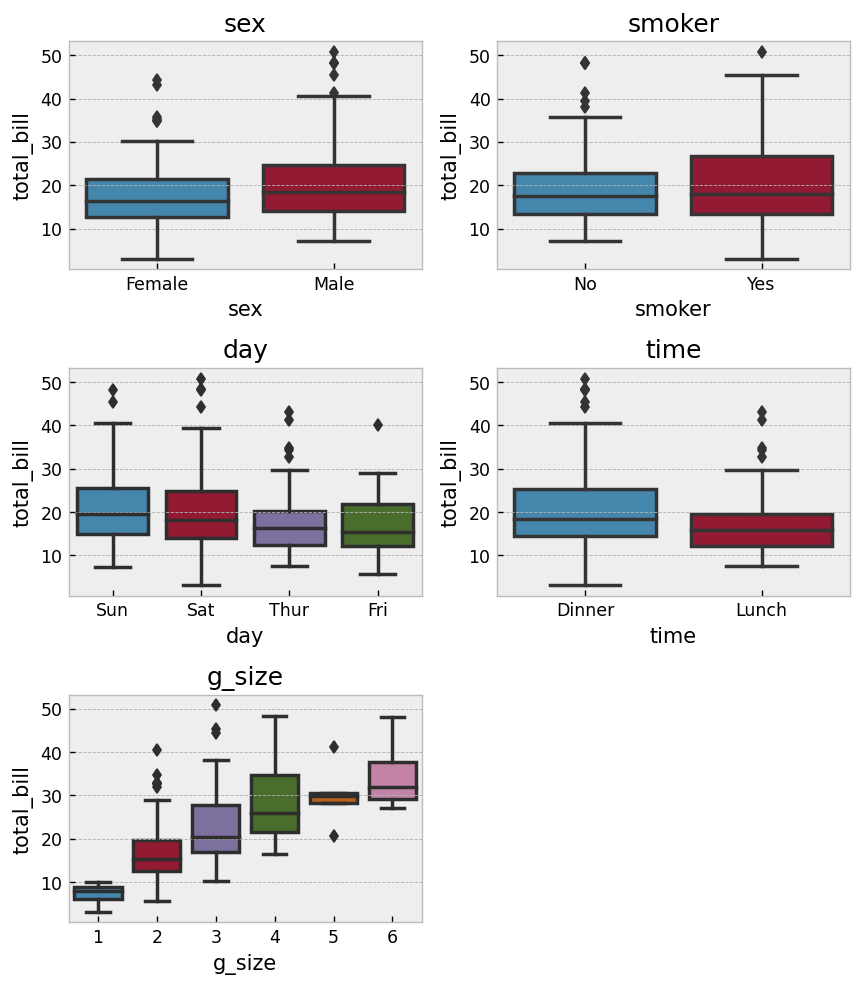

In [6]:
#Check categorical feature's correlation to label
yy = 'total_bill'
plt.figure(figsize=(7,8), dpi=125)
for i,k in enumerate(disc_dict):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=XY[k], y=yy, data=XY)
    plt.title(k)
    plt.tight_layout()

plt.show

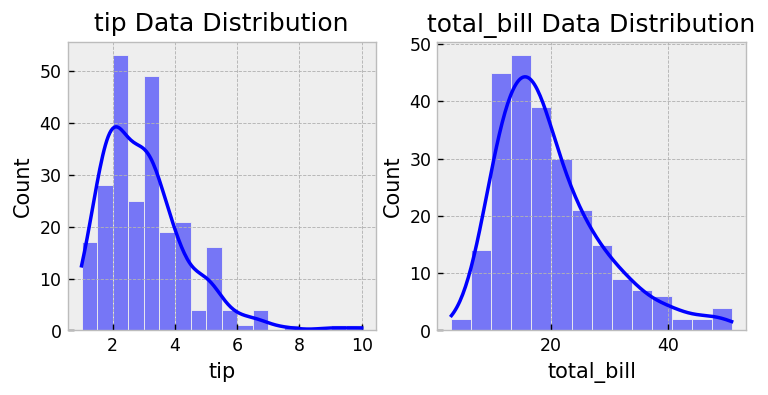

In [7]:
# Check distribution of continuous features

plt.figure(figsize=(7,3), dpi=125)
plt.subplot(1,2,1)
sns.histplot(data=XY, x='tip', kde=True)
plt.title('tip Data Distribution')

plt.subplot(1,2,2)
sns.histplot(data=XY, x='total_bill', kde=True)
plt.title('total_bill Data Distribution')
plt.show()

0.6757341092113647


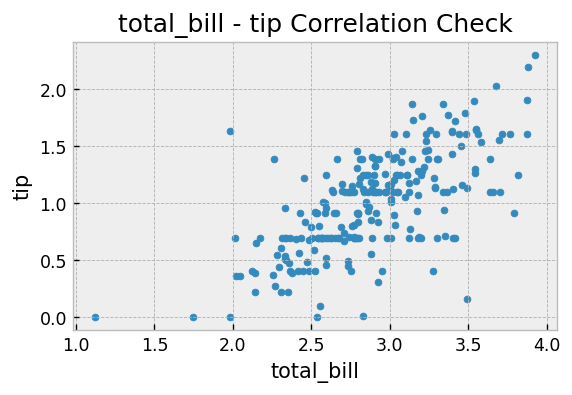

In [8]:
# 
from scipy.stats import pearsonr

corr, _ = pearsonr(XY['total_bill'].to_numpy(),XY['tip'].to_numpy())
print(corr)

a = np.log(XY['total_bill'].to_numpy())
b = np.log(XY['tip'].to_numpy())

plt.figure(figsize=(5,3), dpi=125)
plt.scatter(a,b, s=15)
plt.xlabel("total_bill")
plt.ylabel("tip")
plt.title('total_bill - tip Correlation Check')
plt.show()

In [9]:
#Fit the pipe for data transformation
lr_pipe = TipsPipe()
lr_pipe.make_preprocessor(cat_list=['time'], num_list=['tip'], count_list=['g_size'], pass_list=[])
x,y = dataset.get_train_data()
xval, yval = dataset.get_val_data()
lr_pipe.train_pipe()
xtrain_pipe = lr_pipe.transform_data(x)
xval_pipe = lr_pipe.transform_data(xval)

In [10]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet, RidgeCV, Lasso
from sklearn.pipeline import Pipeline
import joblib
import pathlib 

DATA_DIR = pathlib.Path().resolve() / "data"

regressors = {'Linear_regression': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': Lasso(alpha=0.001), 'Elasticnet': ElasticNet(alpha=0.1, l1_ratio=0.4)}
preds_lin = {}
for k,v in regressors.items():
    lin_pipe = Pipeline(steps=[lr_pipe.get_preprocessor(), ('model',v)])

    lin_pipe.fit(x,y)
        
    fname = DATA_DIR / str(k + '.joblib')
    joblib.dump(lin_pipe, fname)
    
    y_hat = lin_pipe.predict(xval)
    
    r2 = r2_score(yval, y_hat)
    rmse1 = np.sqrt(mean_squared_error(yval, y_hat))
    mae = mean_absolute_error(yval, y_hat)
    mape = mean_absolute_percentage_error(yval, y_hat)
    print(f'{k} model r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')
    
    preds_lin[k] = np.array(y_hat).reshape(len(y_hat),1)

Linear_regression model r2 score: 0.516, rmse: 6.608, mae: 4.927, mape: 0.251
Ridge model r2 score: 0.515, rmse: 6.610, mae: 4.959, mape: 0.255
Lasso model r2 score: 0.515, rmse: 6.609, mae: 4.928, mape: 0.251
Elasticnet model r2 score: 0.512, rmse: 6.635, mae: 5.002, mape: 0.259


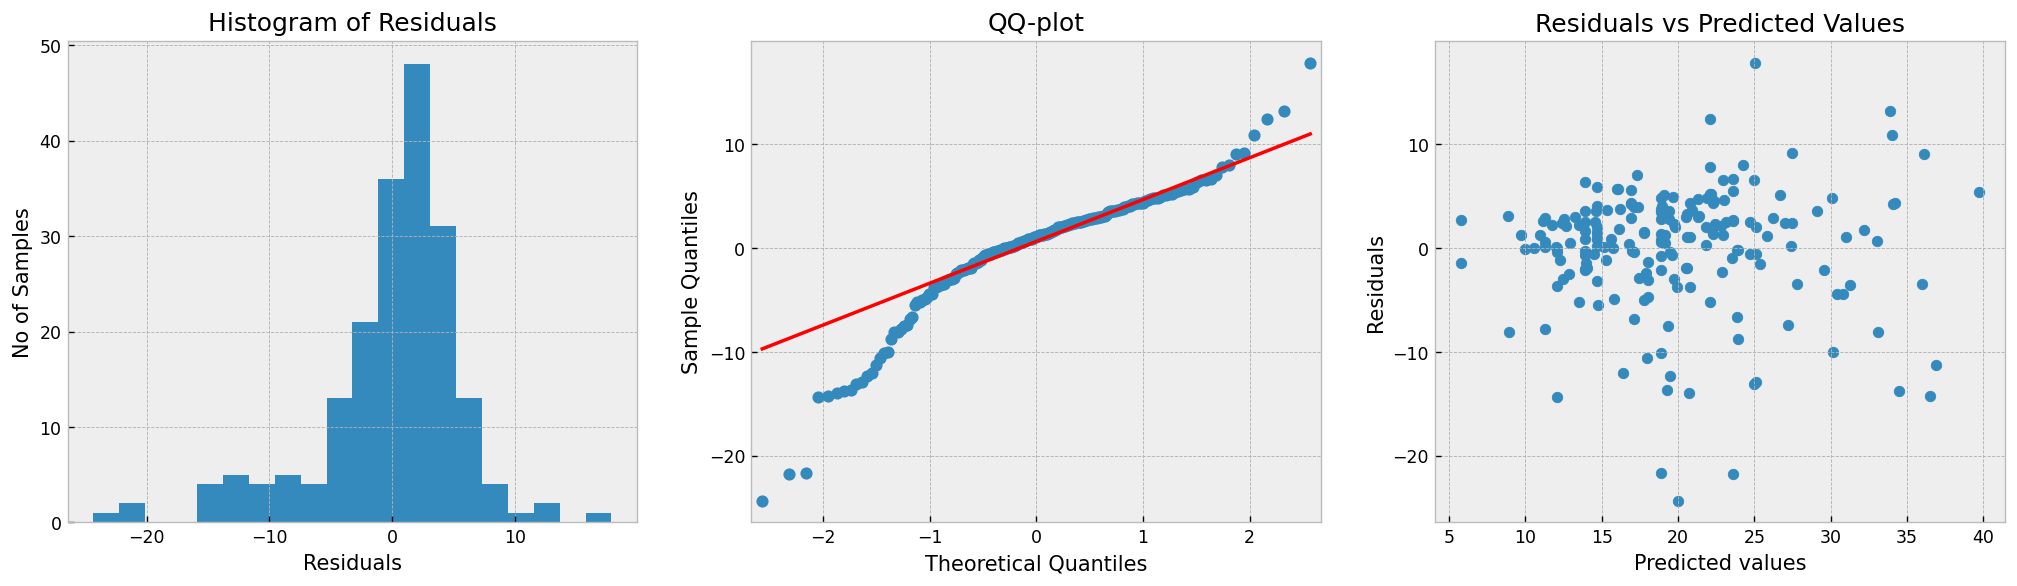

In [11]:
# Add residual normality check
import statsmodels.api as sm

model = joblib.load('data/Linear_regression.joblib')

pred_train = model.predict(x)
residuals = pred_train - y.to_numpy()

fig = plt.figure(figsize=(20,5), dpi=125)
ax1 = fig.add_subplot(1,3,1)
plt.hist(residuals, bins=20)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('No of Samples')
ax1.set_title('Histogram of Residuals')

ax2 = fig.add_subplot(1,3,2)
sm.qqplot(residuals[:,0], line='q', ax=ax2)
ax2.set_title('QQ-plot')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(pred_train, residuals)
ax3.set_xlabel("Predicted values")
ax3.set_ylabel("Residuals")
ax3.set_title("Residuals vs Predicted Values")
fig.show()

In [12]:
x,y = dataset.get_train_data()
xval, yval = dataset.get_val_data()
tt_pipe = TipsPipe()
regressors = {'Linear_regression': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': Lasso(alpha=0.001), 'Elasticnet': ElasticNet(alpha=0.1, l1_ratio=0.4)}
preds_tt = {}
for k,v in regressors.items():
    tt_linreg = tt_pipe.make_preprocessor2(cat_list=['time'], num_list=['tip'], 
                                           count_list=['g_size'], pass_list=[], model=v)
    fname = DATA_DIR / str('tt' + k + '.joblib')
    joblib.dump(tt_linreg, fname)
    y_hat = tt_linreg.predict(xval)
    
    r2 = r2_score(yval, y_hat)
    rmse1 = np.sqrt(mean_squared_error(yval, y_hat))
    mae = mean_absolute_error(yval, y_hat)
    mape = mean_absolute_percentage_error(yval, y_hat)
    print(f'{k} model r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')
        
    preds_tt[k] = np.array(y_hat).reshape(len(y_hat),1)

Linear_regression model r2 score: 0.530, rmse: 6.512, mae: 4.760, mape: 0.238
Ridge model r2 score: 0.528, rmse: 6.522, mae: 4.782, mape: 0.240
Lasso model r2 score: 0.529, rmse: 6.516, mae: 4.767, mape: 0.238
Elasticnet model r2 score: 0.508, rmse: 6.656, mae: 4.934, mape: 0.251


In [13]:
model = joblib.load('data/ttLinear_regression.joblib')
print(model.regressor_[:-1].get_feature_names_out())

['log_nums__tip' 'nums__g_size' 'cats__time_Lunch']


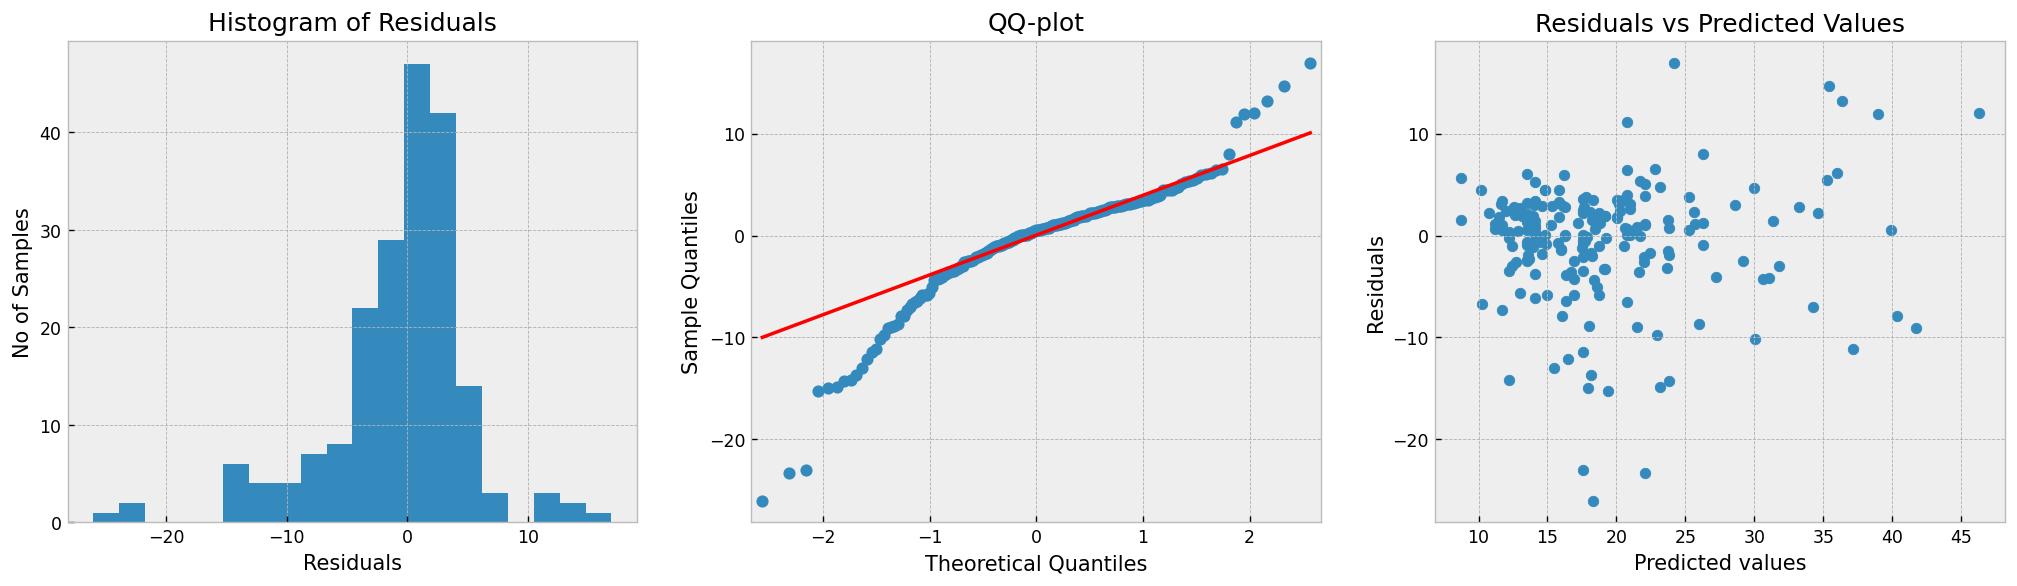

In [14]:
# Add residual normality check
import statsmodels.api as sm

model = joblib.load('data/ttLinear_regression.joblib')

pred_train = model.predict(x)
residuals = pred_train - y.to_numpy()

fig = plt.figure(figsize=(20,5), dpi=125)
ax1 = fig.add_subplot(1,3,1)
plt.hist(residuals, bins=20)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('No of Samples')
ax1.set_title('Histogram of Residuals')

ax2 = fig.add_subplot(1,3,2)
sm.qqplot(residuals[:,0], line='q', ax=ax2)
ax2.set_title('QQ-plot')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(pred_train, residuals)
ax3.set_xlabel("Predicted values")
ax3.set_ylabel("Residuals")
ax3.set_title("Residuals vs Predicted Values")
fig.show()

5% largest neg error: -6.07,
95% largest pos error: 12.36


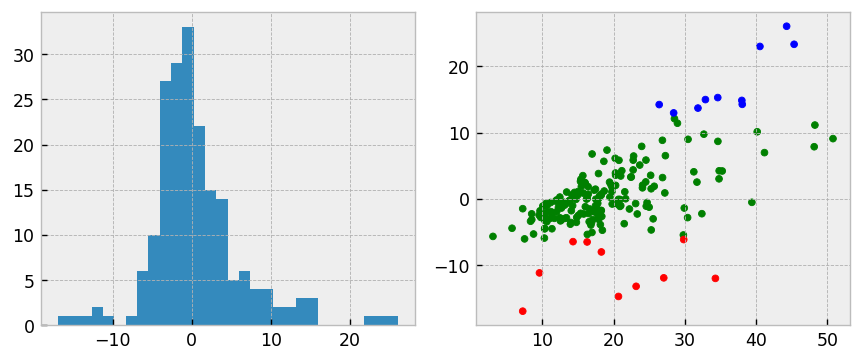

In [15]:

pred_train = model.predict(x)
res_error = y - pred_train

error_arr = np.concatenate((y, pred_train, res_error, x), axis=1)

er_df = pd.DataFrame(data=error_arr, columns=['y', 'pred','error'] + x.columns.to_list())

large_neg_res = res_error.quantile(.05)[0]
large_pos_res = res_error.quantile(.95)[0]

def col_fcn(row):
    if row['error'] < large_neg_res:
        return 'red'
    elif row['error'] > large_pos_res:
        return 'blue'
    else: return 'green'

er_df['color'] = er_df.apply(col_fcn, axis=1)


print(f'5% largest neg error: {large_neg_res:.2f},\n95% largest pos error: {large_pos_res:.2f}')

color_list = ['red', 'green', 'blue']

plt.figure(figsize=(7,3), dpi=125)
plt.subplot(1,2,1)
plt.hist(res_error, bins=30)

plt.subplot(1,2,2)
plt.scatter(y, res_error, color = er_df.color.to_list(), s=15)
plt.tight_layout()
plt.show()


In [16]:
display(er_df[(er_df['error'] > large_pos_res) | (er_df['error'] < large_neg_res)].sort_values(by=['color', 'error'], ascending=True))

,y,pred,error,tip,sex,smoker,day,time,g_size,color
192,28.44,15.478738,12.961262,2.56,Male,Yes,Thur,Lunch,2,blue
173,31.85,18.159465,13.690535,3.18,Male,Yes,Sun,Dinner,2,blue
57,26.41,12.192835,14.217165,1.5,Female,No,Sat,Dinner,2,blue
112,38.07,23.815145,14.254855,4.0,Male,No,Sun,Dinner,3,blue
56,38.01,23.165198,14.844802,3.0,Male,Yes,Sat,Dinner,4,blue
175,32.9,17.929022,14.970978,3.11,Male,Yes,Sun,Dinner,2,blue
179,34.63,19.356674,15.273326,3.55,Male,Yes,Sun,Dinner,2,blue
184,40.55,17.564222,22.985778,3.0,Male,Yes,Sun,Dinner,2,blue
182,45.35,22.039115,23.310885,3.5,Male,Yes,Sun,Dinner,3,blue
102,44.3,18.267804,26.032196,2.5,Female,Yes,Sat,Dinner,3,blue


-0.03817664667898743


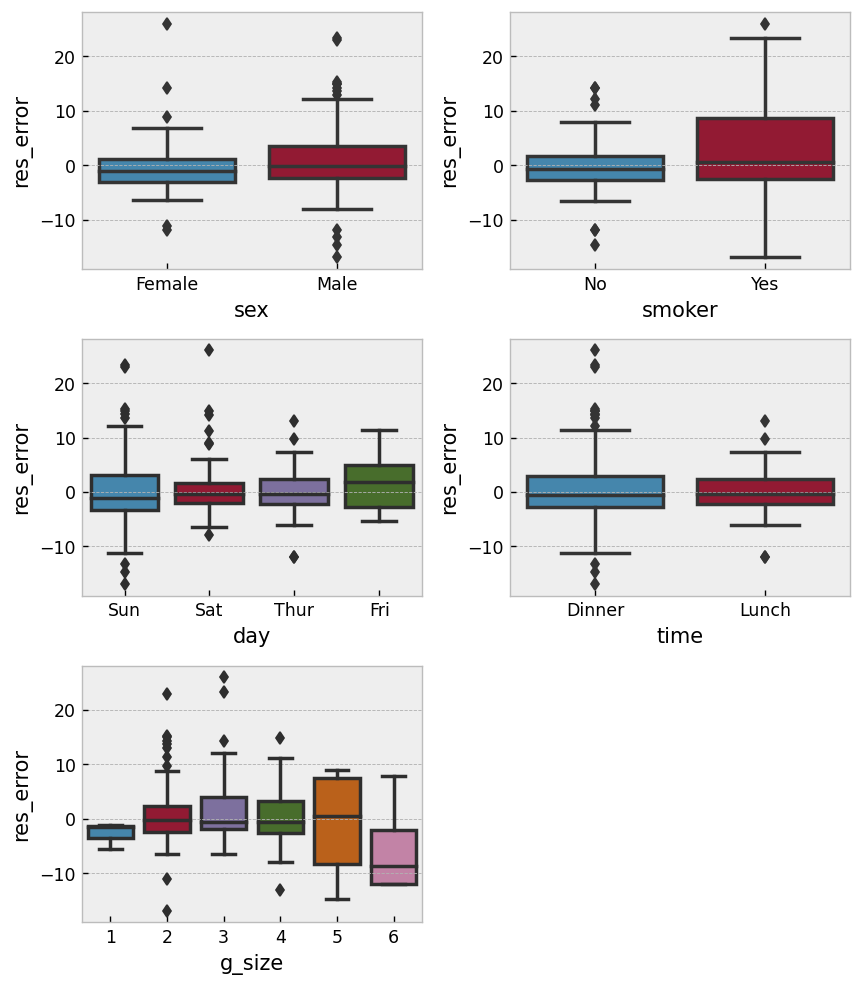

In [17]:
#Check categorical feature's correlation to label
x['res_error'] = res_error['total_bill']

corr, _ = pearsonr(x['res_error'].to_numpy(),x['tip'].to_numpy())
print(corr)

plt.figure(figsize=(7,8), dpi=125)
for i,k in enumerate(disc_dict):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=x[k], y='res_error', data=x)
    plt.tight_layout()

plt.show()

In [18]:
#Fit the pipe for data transformation
xgb_pipe = TipsPipe()
xgb_pipe.make_preprocessor(cat_list=['sex','smoker','day','time'], num_list=['tip'], count_list=['g_size'], pass_list=[])
x,y = dataset.get_train_data()
xval, yval = dataset.get_val_data()
xgb_pipe.train_pipe()
xtrain_pipe = xgb_pipe.transform_data(x)
xval_pipe = xgb_pipe.transform_data(xval)

features = xgb_pipe.get_pipe()['preprocessor'].get_feature_names_out()
print(features)

['log_nums__tip' 'nums__g_size' 'cats__sex_Male' 'cats__smoker_Yes'
 'cats__day_Sat' 'cats__day_Sun' 'cats__day_Thur' 'cats__time_Lunch']


In [19]:
from xgboost import XGBRegressor

#Test model
eval_set = [(xtrain_pipe,y), (xval_pipe, yval)]
eval_metrics = ['mae']

model = XGBRegressor(use_label_encoder=False, n_estimators=6)

xgb_trained = model.fit(xtrain_pipe,y,
             eval_set=eval_set,
             eval_metric=eval_metrics,
             verbose=True)

[0]	validation_0-mae:13.73855	validation_1-mae:13.50969
[1]	validation_0-mae:9.88998	validation_1-mae:9.83238
[2]	validation_0-mae:7.15598	validation_1-mae:7.19340
[3]	validation_0-mae:5.34494	validation_1-mae:5.66440
[4]	validation_0-mae:4.15764	validation_1-mae:4.95919
[5]	validation_0-mae:3.43744	validation_1-mae:4.73040


[0.27880418 0.41353115 0.05695689 0.06842218 0.03553468 0.14154032
 0.00521053 0.        ]


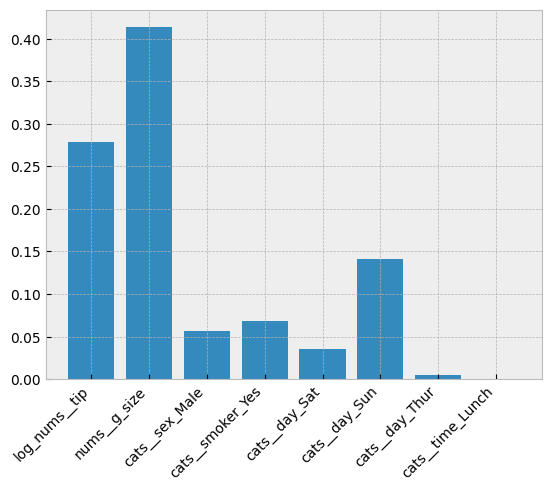

In [21]:
print(xgb_trained.feature_importances_)

plt.figure()
plt.bar(features, xgb_trained.feature_importances_)
plt.xticks(rotation=45, ha='right')
plt.show()

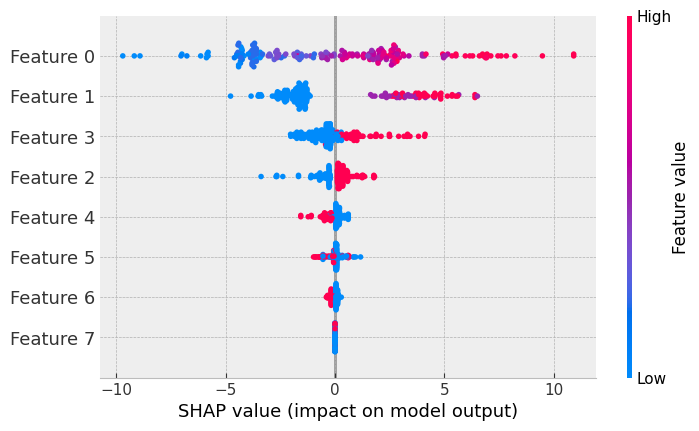

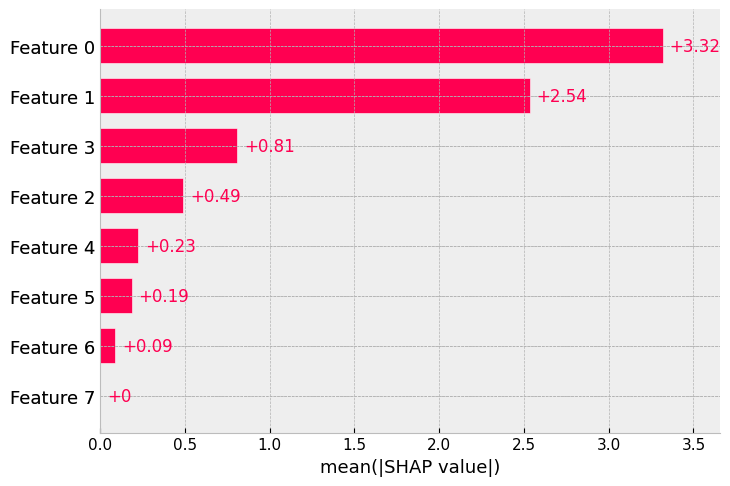

In [22]:
import shap
explainer = shap.Explainer(xgb_trained)
shap_values = explainer(xtrain_pipe)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)